<a href="https://www.kaggle.com/code/mohamedmalkyasser/anime-recommendations-system?scriptVersionId=123754485" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as py
import seaborn as sb

import charset_normalizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

# Load Data

In [2]:
anime = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv').set_index('anime_id')
anime.head(5)

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
data = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')
data.head(5)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [3]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12294 entries, 32281 to 26081
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      12294 non-null  object 
 1   genre     12232 non-null  object 
 2   type      12269 non-null  object 
 3   episodes  12294 non-null  object 
 4   rating    12064 non-null  float64
 5   members   12294 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 672.3+ KB


In [4]:
anime.isnull().sum()

name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

# Some EDA

## Name
> The **Anime** may have more than one season or be a series and have a version as a movie. In this case a large proportion will bear the same ***title***.
> 
>This means that the **Anime** ***titles*** affect how similar the **Animes** are, and therefore the **Anime** ***title*** must be taken into account when finding similar **Animes**. 

> Maybe ***Titles*** have similar mean

In [4]:
anime.name[anime.name.duplicated()]

anime_id
30059           Saru Kani Gassen
33195    Shi Wan Ge Leng Xiaohua
Name: name, dtype: object

In [5]:
anime[anime.name == 'Saru Kani Gassen']

,name,genre,type,episodes,rating,members
anime_id,,,,,,
22399,Saru Kani Gassen,Kids,OVA,1,5.23,62
30059,Saru Kani Gassen,Drama,Movie,1,4.75,76


In [7]:
anime[anime.name == 'Shi Wan Ge Leng Xiaohua']

,name,genre,type,episodes,rating,members
anime_id,,,,,,
33193,Shi Wan Ge Leng Xiaohua,"Comedy, Parody",ONA,12,6.67,114
33195,Shi Wan Ge Leng Xiaohua,"Action, Adventure, Comedy, Fantasy, Parody",Movie,1,7.07,110


**Here**
1. There are 2-animes have the same title **`Saru Kani Gassen`**
> * *22399* **ID** for *Kids* & *OVA* type
> * *30059* **ID** is *Drama* & *Movie* type
>
2. There are 2-animes have the same title **`Shi Wan Ge Leng Xiaohua`**
> * *33193* **ID** for *Comedy - Parody* & *ONA* type
> * *33195* **ID** is *Action - Adventure - Comedy - Parody - Fantasy* & *Movie* type

-------

In [8]:
anime.loc[28977]

name                                                 Gintama°
genre       Action, Comedy, Historical, Parody, Samurai, S...
type                                                       TV
episodes                                                   51
rating                                                   9.25
members                                                114262
Name: 28977, dtype: object

In [6]:
anime.loc[9969]

name                                            Gintama&#039;
genre       Action, Comedy, Historical, Parody, Samurai, S...
type                                                       TV
episodes                                                   51
rating                                                   9.16
members                                                151266
Name: 9969, dtype: object

In [10]:
anime.loc[6133]

name        Violence Gekiga Shin David no Hoshi: Inma Dens...
genre                                                  Hentai
type                                                      OVA
episodes                                                    1
rating                                                   4.98
members                                                   175
Name: 6133, dtype: object

In [11]:
anime.loc[5621]

name        Violence Gekiga David no Hoshi
genre                               Hentai
type                                   OVA
episodes                                 4
rating                                4.88
members                                219
Name: 5621, dtype: object

**Here**
1. The **`Gintama°`** and **`Gintama&#039;`** have the similar ***title*** and have the similar features.
2. The **`Violence Gekiga Shin David no Hoshi: Inma Dens...°`** and **`Violence Gekiga David no Hosh`** have the similar ***title*** and have the similar features.

## Genre
The **Anime** can be categorized into more than one **genre**.

The missing values in this column not removed, because after handling this problem is solved.

In [4]:
animes_genre = anime.genre.copy()
animes_genre

anime_id
32281                 Drama, Romance, School, Supernatural
5114     Action, Adventure, Drama, Fantasy, Magic, Mili...
28977    Action, Comedy, Historical, Parody, Samurai, S...
9253                                      Sci-Fi, Thriller
9969     Action, Comedy, Historical, Parody, Samurai, S...
                               ...                        
9316                                                Hentai
5543                                                Hentai
5621                                                Hentai
6133                                                Hentai
26081                                               Hentai
Name: genre, Length: 12294, dtype: object

In [13]:
anime[animes_genre.isnull()]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
33589,ViVid Strike!,NaN,TV,12,6.96,12345
29765,Metropolis (2009),NaN,Movie,1,6.27,313
32695,Match Shoujo,NaN,ONA,1,6.02,242
33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...
32032,Seikaisuru Kado,NaN,NaN,Unknown,NaN,1797
34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,NaN,51
34474,Tsukipro The Animation,NaN,TV,Unknown,NaN,843


In [14]:
animes_genre.value_counts()

Hentai                                                  823
Comedy                                                  523
Music                                                   301
Kids                                                    199
Comedy, Slice of Life                                   179
                                                       ... 
Adventure, Drama, Fantasy, Game, Sci-Fi                   1
Adventure, Demons, Fantasy, Historical                    1
Action, Comedy, Drama, Mecha, Music, Sci-Fi, Shounen      1
Action, Comedy, Fantasy, Mecha, Sci-Fi, Shounen           1
Hentai, Slice of Life                                     1
Name: genre, Length: 3264, dtype: int64

> The **Genre** column is a list containing a number of **genres**, which vary in size, and encompass duplicate **genres**. 
>
> In this way, it cannot be included in any algorithm, and it cannot be neglected because it is a critical feature of **Anime**.
>
> This column is considered a nominal feature, but in a different manner. where for example, 
> * the **genre** for **Anime** of **ID** *32281* is `Drama Romance School Supernatural`, this mean that **genre** is `Drama` & `Romance` & `School` & `Supernatural` only. and all other **genres** *NO*.
> * This mean that can be make each **genre** as column and in case, the one of **genres** for an **Anime** containes it, then, the column is **True** for this **Anime**. 
> This is ***`dummy feature`***.
> * **`Missing Values`** are Solved. for **Anime** doesn't have any **Genre**, all columns of new dataframe is set to **Zero**. this mean this **Anime** doesn't have any **Genre**. 

In [4]:
def handle_genre(genre_series):
    """
    Make Dummy for Genre Feature
       
    :param genre_series: Genre column
    :return: Dummy DataFrame, columns are uniqe genres & rows are anime id
    """
    
    genres = []
    
    # extract all genres of Anime, duplicated genres
    for genre in genre_series:
        genres.extend(str(genre).strip()\
                      .replace(', ', ',').replace(' ,', ',').upper().split(','))
        pass
    
    genres = np.unique(genres) # get only the unique genres
    print(f"Number of Unique \033[1mGenres\033[0m is {len(genres)}")
    
    # Make Dataframe contains 
       # unique genres as columns
       # animes (anime id) as rows
       # Do the anime genres contain this genres as cell-value
    # i.e, Make Dummy Feature 
    data_frame = pd.DataFrame(columns=genres, index= genre_series.index).fillna(0)
    
    # Fill Dataframe { 1:genre-included, 0:not-included}
    for ind in genre_series.index:
        for gen in str(genre_series.loc[ind]).strip()\
                      .replace(', ', ',').replace(' ,', ',').upper().split(','): 
            data_frame.loc[ind][gen] = 1
            pass
        pass
    return data_frame

In [14]:
genres = handle_genre(anime.genre.copy())
genres.head(5)

Number of Unique Genres is 44


,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# get the most frequent Genre in Anime dataset
temp = pd.DataFrame(data=[(genres.columns[i], genres.iloc[:,i].value_counts().iloc[-1]) for i in range(44)]).set_index(0)
temp.sort_values(by=1, ascending=False)

,1
0,
COMEDY,4645
ACTION,2845
ADVENTURE,2348
FANTASY,2309
SCI-FI,2070
DRAMA,2016
SHOUNEN,1711
KIDS,1609
ROMANCE,1464


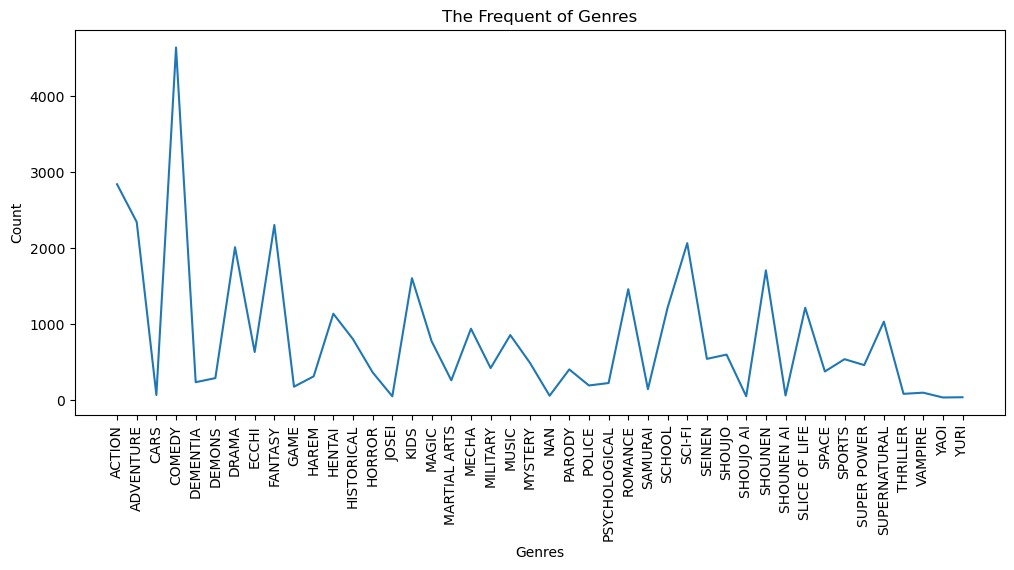

In [14]:
py.figure(figsize=(12,5))
py.plot(temp)
py.title('The Frequent of Genres'); py.xlabel('Genres'); py.ylabel('Count')
py.xticks(rotation=90); py.show()

> ***Comedy*** **Animes** are most frequent, this maybe indicate that most recommanded Animes are ***Comedy*** 

-------------

## Type
> Everyone tends to watch a certain **Type** of **Anime**, for example ***TV Series*** have `more episodes and can develop the story and characters`. but ***Movies*** have a `shorter run time and can tell a complete story in one sitting` 

<AxesSubplot:xlabel='type', ylabel='count'>

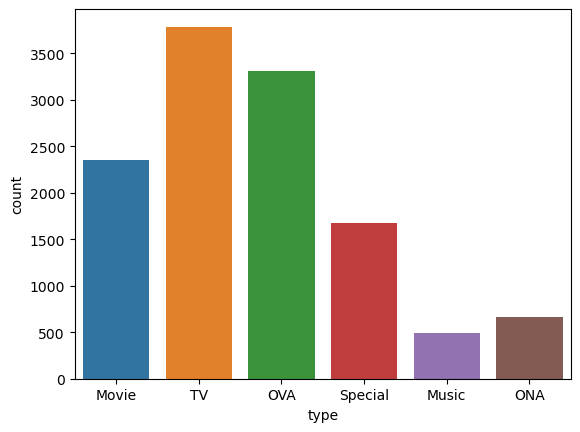

In [19]:
sb.countplot(x=anime.type)

> **`TV OVA Movie`** are most frequent, this indecate that the **type** of most Recommended **Animes** will be these.

---------------

In [17]:
temp = pd.concat([anime.type,  genres], axis=1)
temp.head(4)

,type,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,Movie,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,TV,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
28977,TV,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,TV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:xlabel='type', ylabel='count'>

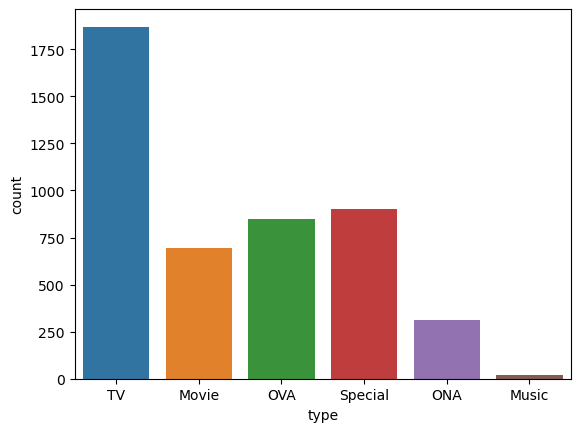

In [21]:
sb.countplot(x=temp.type[temp['COMEDY'] == 1])

<AxesSubplot:xlabel='type', ylabel='count'>

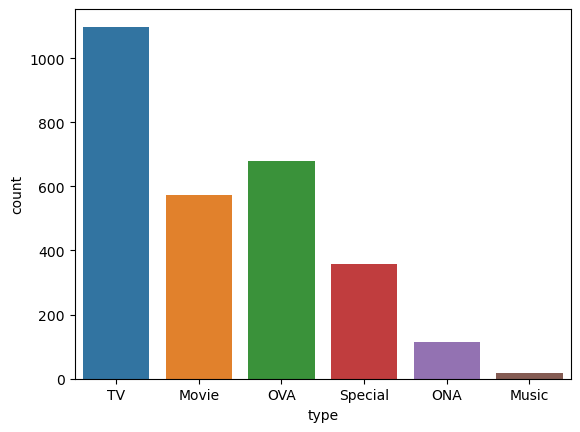

In [22]:
sb.countplot(x=temp.type[temp['ACTION'] == 1])

## Episodes
> Popularity of **Anime** can depend on many factors such as the `storyline, characters, animation quality and more`. 
> 
> Some long-running animes have maintained their popularity over time while others with fewer **episodes** have also gained a large following. Ultimately, 
>
> It’s up to **`individual preferences`**.

In [9]:
print("percentage of missing values of episodes : ", 
      (len(anime.episodes[anime.episodes == 'Unknown']) / anime.episodes.shape[0] ) * 100)

percentage of missing values of episodes :  2.7655767040832924


In [8]:
episodes = anime.episodes.copy()
episodes.unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

> **episodes** is `object data-type` should be handled. and ***Unknown** value replaced by *Zero* 

In [10]:
episodes = episodes.replace('Unknown', 0).astype(np.int16)

<AxesSubplot:xlabel='episodes', ylabel='Density'>

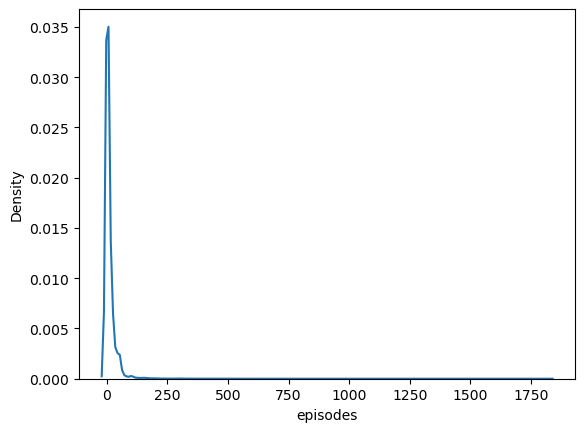

In [12]:
sb.kdeplot(episodes)

-----

## Rating
> **Rating** of **Anime** indecates to the **Anime** ***popularity***.

<AxesSubplot:xlabel='rating', ylabel='Density'>

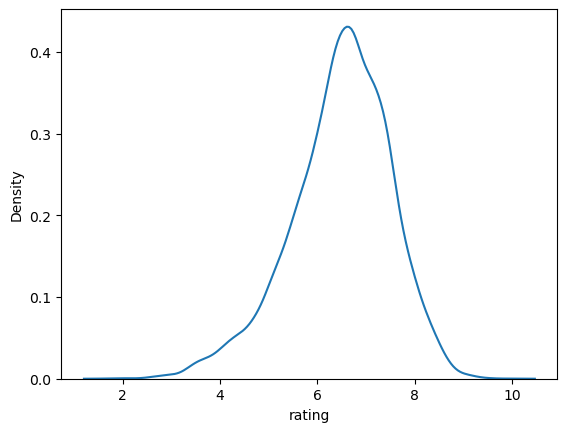

In [27]:
sb.kdeplot(anime.rating)

<AxesSubplot:xlabel='episodes', ylabel='rating'>

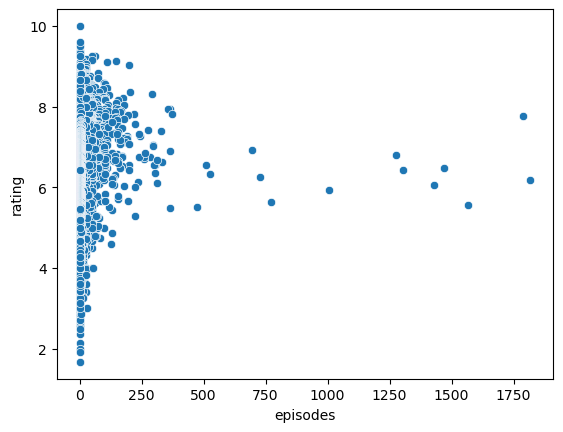

In [28]:
sb.scatterplot(x=episodes,y=anime.rating)

> Nubmer of **episodes** doesn't affect on the **popularity** of **Anime**
>
> This means that everyone has their own preferences.

<AxesSubplot:xlabel='type', ylabel='rating'>

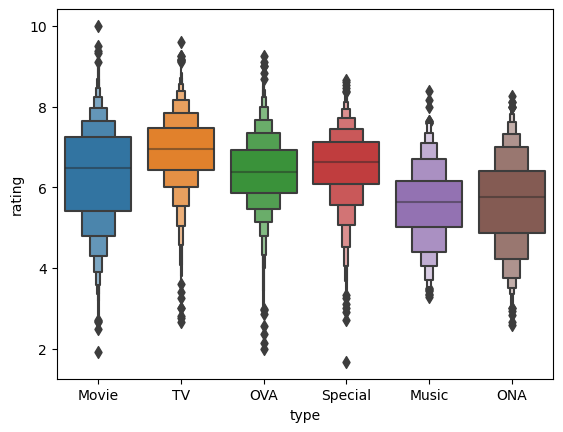

In [29]:
sb.boxenplot(x=anime.type, y=anime.rating)

> The **popularity** of **Anime**, the approximately  the same over **Types**. But
>
> ***TV*** has somewhat higher **ratings** 
>
> This means that everyone has their own preferences.

Text(0.5, 1.0, 'Show Affact of Anime Genre on rating')

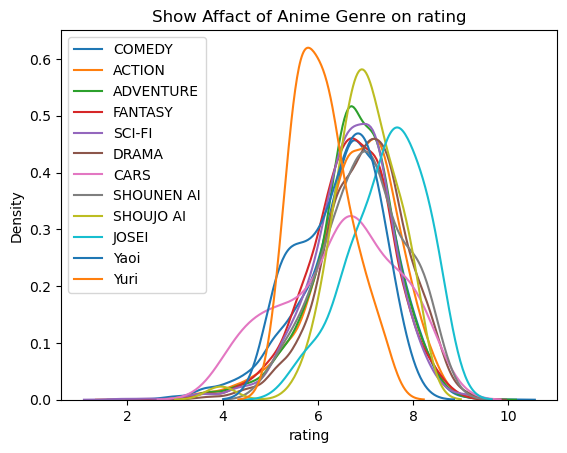

In [18]:
# top frequent anime types
sb.kdeplot(x=anime.rating[temp['COMEDY'] == 1], label='COMEDY')
sb.kdeplot(x=anime.rating[temp['ACTION'] == 1], label='ACTION')
sb.kdeplot(x=anime.rating[temp['ADVENTURE'] == 1], label='ADVENTURE')
sb.kdeplot(x=anime.rating[temp['FANTASY'] == 1], label='FANTASY')
sb.kdeplot(x=anime.rating[temp['SCI-FI'] == 1], label='SCI-FI')
sb.kdeplot(x=anime.rating[temp['DRAMA'] == 1], label='DRAMA')
# less frequent anime types
sb.kdeplot(x=anime.rating[temp['CARS'] == 1], label='CARS')
sb.kdeplot(x=anime.rating[temp['SHOUNEN AI'] == 1], label='SHOUNEN AI')
sb.kdeplot(x=anime.rating[temp['SHOUJO AI'] == 1], label='SHOUJO AI')
sb.kdeplot(x=anime.rating[temp['JOSEI'] == 1], label='JOSEI')
sb.kdeplot(x=anime.rating[temp['YAOI'] == 1], label='Yaoi')
sb.kdeplot(x=anime.rating[temp['YURI'] == 1], label='Yuri')

py.legend(); py.title('Show Affact of Anime Genre on rating')

> The **popularity** of **Anime**, the approximately  the same over **Types**. But
>
> This ensure that everyone has their own preferences.

----------

## Members
> Members are not affact on the **Anime** popularity 

<AxesSubplot:xlabel='members', ylabel='Density'>

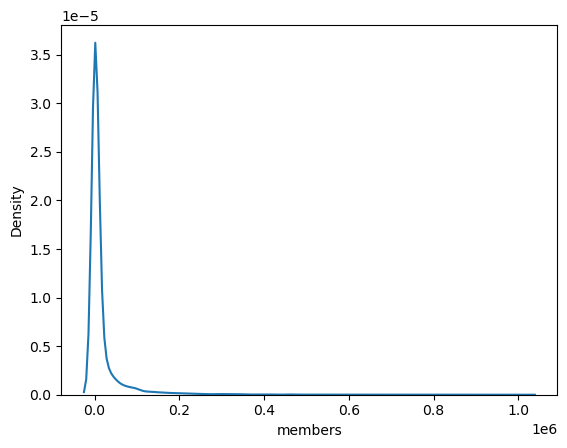

In [31]:
sb.kdeplot(x=anime.members)

<AxesSubplot:xlabel='type', ylabel='members'>

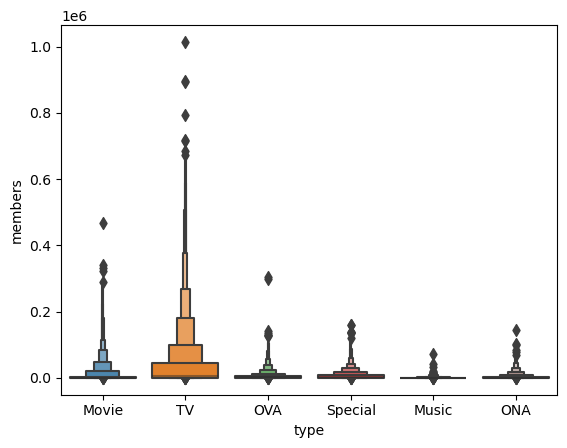

In [32]:
sb.boxenplot(x=anime.type, y=anime.members)

<AxesSubplot:xlabel='members', ylabel='rating'>

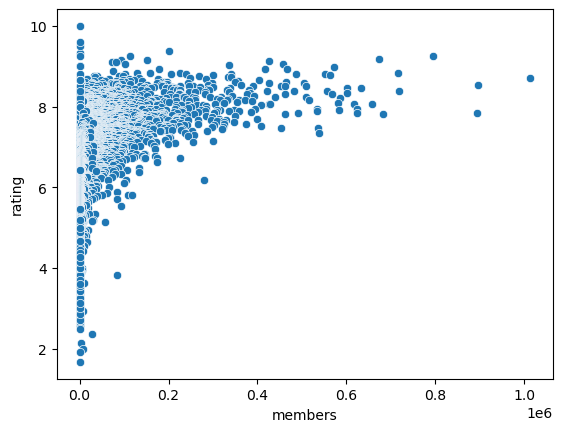

In [33]:
sb.scatterplot(x=anime.members, y=anime.rating)

--------------

# Preprocessing

In [5]:
# drop nulls
metadata = anime[~ anime.type.isnull()]
# remove members column
metadata = metadata.drop(['members'], axis=1)

In [6]:
metadata.episodes = metadata.episodes.replace('Unknown', 0).astype(np.int16)

In [7]:
genres = handle_genre(metadata.genre)
genres.head(5)

Number of Unique Genres is 44


,ACTION,ADVENTURE,CARS,COMEDY,DEMENTIA,DEMONS,DRAMA,ECCHI,FANTASY,GAME,...,SHOUNEN AI,SLICE OF LIFE,SPACE,SPORTS,SUPER POWER,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
titles = metadata.name
titles.head(5)

anime_id
32281                      Kimi no Na wa.
5114     Fullmetal Alchemist: Brotherhood
28977                            Gintama°
9253                          Steins;Gate
9969                        Gintama&#039;
Name: name, dtype: object

In [9]:
metadata.drop(['name', 'genre'], axis=1, inplace=True)

In [10]:
# handle name 
tf = TfidfVectorizer(stop_words='english')
vectorized_txt = tf.fit_transform(titles)

In [12]:
vectorized_txt.shape

(12269, 11975)

In [11]:
vectorized_txt = pd.DataFrame(vectorized_txt.toarray()).set_index(metadata.index)

In [14]:
vectorized_txt.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11965,11966,11967,11968,11969,11970,11971,11972,11973,11974
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
metadata = pd.concat([metadata, vectorized_txt, genres], axis=1)

In [13]:
metadata = pd.get_dummies(metadata, columns=['type'], drop_first=True)

In [17]:
metadata.head(5)

,episodes,rating,0,1,2,3,4,5,6,7,...,SUPERNATURAL,THRILLER,VAMPIRE,YAOI,YURI,type_Music,type_ONA,type_OVA,type_Special,type_TV
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,1,9.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
5114,64,9.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
28977,51,9.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
9253,24,9.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
9969,51,9.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
metadata = metadata[~ metadata.rating.isnull()]
metadata.index.rename('item_id', inplace=True)
data.rename(columns={'anime_id': 'item_id'}, inplace=True)

# Build Recommendation System Models

In [27]:
class Recommendation_System():
    def __init__(self, dataset, metadataset, contentset):
        """
        :param dataset: dataset contains ratings of users on items
        :param metadataset: dataset contains the title of items
        :param contentset: dataset contains the attributes of items
        """
        
#         if list(dataset.columns) != ['item_id', 'user_id', 'rating']:
#             raise TypeError("Dataset columns should be ['item_id', 'user_id', 'rating']")
#             pass
        if metadataset.index.name != 'item_id': raise TypeError("Meta Dataset index sould be item_id")
        
        self.type = None
        self.data = dataset
        self.titles = contentset
        self.metadata = metadataset
        self.similarity_matrix = []
    
    def fit_similarity(self, recommend_type):
        if recommend_type == 'user':
            pivot_table = self.data.pivot_table(
                values='rating', index='user_id', columns='item_id').fillna(0)
            pass
        elif recommend_type == 'item':
            pivot_table = self.data.pivot_table(
                values='rating', index='item_id', columns='user_id').fillna(0)
            pass
        elif recommend_type == 'content':
            pivot_table = self.metadata
            pass
        elif recommend_type == 'hybrid' or recommend_type == 'recommend':
            # user
            pivot_table = self.data.pivot_table(
                values='rating', index='user_id', columns='item_id').fillna(0)
            user_sim = pd.DataFrame(data= cosine_similarity(pivot_table, pivot_table),
                            index= pivot_table.index, columns=pivot_table.index)
            
            # item
            pivot_table = self.data.pivot_table(
                values='rating', index='item_id', columns='user_id').fillna(0)
            item_sim = pd.DataFrame(data= cosine_similarity(pivot_table, pivot_table),
                            index= pivot_table.index, columns=pivot_table.index)
            
            # content
            pivot_table = self.metadata
            cont_sim = pd.DataFrame(data= cosine_similarity(pivot_table, pivot_table),
                            index= pivot_table.index, columns=pivot_table.index)
            
            self.similarity_matrix = (user_sim, item_sim, cont_sim)
            self.type = recommend_type 
            return
        else :
            raise TypeError('Must be \033[1m user | item | content | hybrid | recommend\033[0m')
    
        self.type = recommend_type
        self.similarity_matrix = pd.DataFrame(data= cosine_similarity(pivot_table, pivot_table),
                            index= pivot_table.index, columns=pivot_table.index)
        pass
        
    def popular(self, top_items=10):
        # calculate populerity based on number of using and ratings
        count_watch = self.data.item_id.value_counts()
        avg_ratings = self.data.groupby(by='item_id').rating.mean() 
        m = count_watch.quantile(0.9)
        
        popular = ((avg_ratings*count_watch) + (avg_ratings.mean()*m)) / (count_watch+m)
        popular = popular.sort_values(ascending=False).iloc[:top_items]
        return pd.concat([popular, self.titles.loc[popular.index]], axis=1)
    
    def user_based(self, user_id, top_users=10, top_items=10):
        if self.type == None: raise TypeError('Must call \033[1m fit function before\033[0m')
        if self.type != 'user' : raise TypeError('type of Recommendation must be \033[1m user \033[0m')
        
        # get the similar users
        users = self.similarity_matrix[user_id].sort_values(ascending=False)[1: top_users+1]
        # get item that user not watch and the similar users were using to recommand them
        unseen_items = self.data[(self.data.user_id.apply(
            lambda x: x in users.index.values)) & (self.data.user_id != user_id)]
        
        # Calculate the rating for the items that the user is expected to give.
        # in case he used it based on his closest users.
        items = []
        for item in unseen_items.item_id.unique():
            # using percentage to to make popularity play role in recommendation.
            prec_watch = self.data[self.data.item_id == item].count()[0] / self.data.shape[0]
            item_ratings = unseen_items[unseen_items.item_id == item].set_index('user_id')
            # weighted rating, add the similarity score of user as facctor
            rating = ((item_ratings.rating * users[item_ratings.index]).sum() / users.sum())
            items.append([item, rating, rating * prec_watch]) 
            pass
              
        return pd.DataFrame(data= items, columns= ['item_id', 'rating', 'rating with watching percentage'])\
            .set_index('item_id').sort_values(by='rating', ascending=False)[:top_items].join(self.titles)
    
    def item_based(self, item_id, top_items=10): 
        if self.type == None: raise TypeError('Must call \033[1m fit function before\033[0m')
        if self.type != 'item': raise TypeError('type of Recommendation must be \033[1m item \033[0m')
        
        similer = self.similarity_matrix[item_id]
        similer.name = 'Similerity Score'
        
        weigted_sim = (similer * (self.data.item_id.value_counts().loc[similer.index] / self.data.shape[0]))
        weigted_sim.name = 'Weighted Similerity Score'
        
        similer_items = weigted_sim.sort_values(ascending=False)[1: top_items+1]
        similer_items = pd.concat([similer_items, similer.loc[similer_items.index]], axis=1)
        
        return similer_items.join(self.titles)
    
    def content_based(self, item_id, top_items=10):
        if self.type == None: raise TypeError('Must call \033[1m fit function before\033[0m')
        if self.type != 'content': raise TypeError('type of Recommendation must be \033[1m content \033[0m')
        
        similer = self.similarity_matrix[item_id]
        similer.name = 'Similerity Score'
        
        weigted_sim = similer * (self.metadata.loc[similer.index].count() / self.metadata.shape[0])
        weigted_sim.name = 'Weighted Similerity Score'
        
        similer_items = weigted_sim.sort_values(ascending=False)[1: top_items+1]
        similer_items = pd.concat([similer_items, similer.loc[similer_items.index]], axis=1)
        
        return similer_items.join(self.titles)
    
    def hybrid(self, user_id, top=10):
        if self.type == None: raise TypeError('Must call \033[1m fit function before\033[0m')
        if self.type != 'hybrid' and self.type != 'recommend': 
            raise TypeError('type of Recommendation must be \033[1m hybrid or recommend\033[0m')
            
        used_perc = self.data.groupby(by='item_id').item_id.count()
        
        user_based, item_based, content_based = self.similarity_matrix
        
        # get the similar users
        users = user_based[user_id].sort_values(ascending=False)[1: top+1]
        unseen_items = self.data[(self.data.user_id.apply(
            lambda x: x in users.index.values)) & (self.data.user_id != user_id)]
        
        seen_items = self.data.item_id[self.data.user_id == user_id].unique()
       
        items = []
        for item in unseen_items.item_id.unique():
            
            # Calculate ratings based on similar users
              # Exepected Rating that user give it to items, 
              # in case user used them based on the similar users  
            item_ratings = unseen_items[unseen_items.item_id == item].set_index('user_id')
            user_rating = ((item_ratings.rating * users[item_ratings.index]).sum() / users.sum())

            # Calculate the rating of item based on the ratings(behavior), of all users
            # add as weigh
            item_rating = np.mean(item_based.loc[item])
        
            # Calculate rating that user add to items based on his ratings(behavior)
              # on similar items in content
            content_rating = np.mean(content_based.loc[item, seen_items])
            
            # Add used percentage as weight
            used_perc_item = used_perc.loc[item] / self.data.shape[0]
            
            final_rating = (user_rating + item_rating + content_rating) * used_perc_item
            items.append([item, item_rating, user_rating, content_rating, final_rating]) 
            pass
        
        items = pd.DataFrame(items, columns=['item_id', 'item based rating',
                                            'user based rating', 'content based rating', 'hybrid rating']).set_index('item_id')
    
        return items.sort_values(by='hybrid rating', ascending=False).iloc[:top, :].join(self.titles)
    
    def recommend(self, user_id, top_items=10):
        """
        Recommend Items for an User
        
        :param user_id: ID of the user for whom the Anime will be recommended 
        :param top_items: number of items that will be recommended
        
        """
        
        
        if self.type == None: raise TypeError('Must call \033[1m fit function before\033[0m')
        if self.type != 'recommend': raise TypeError('type of Recommendation must be \033[1m recommend \033[0m')
        
        # Popularity
        print(f"Top \033[1m{top_items}\033[0m populer animes are:")
        print(f"\t {self.popular(top_items).iloc[:, -1].values}")
        print('\n\t\t ************************ \n')
        #_____________________________________________________________#
        
        # Content Based
         # for each item, user used it, 
         # recommend the top items are similer for it based on content  
        seen_items = self.metadata.loc[self.data.item_id[self.data.user_id == user_id].unique()]
        unseen_items = self.metadata.loc[self.data.item_id[self.data.user_id != user_id].unique()]
        
        avg_ratings = seen_items.groupby(by='item_id').rating.mean()
        for ind, item in zip(seen_items.index, seen_items.values):
            # make recommendation for items that user likes them
            if avg_ratings.loc[ind] >= avg_ratings.mean():
                print(f"Top \033[1m{top_items}\033[0m related animes for \033[1m{self.titles.loc[ind]}\033[0m are:")
                print(pd.DataFrame(data= cosine_similarity(item.reshape(1,-1), unseen_items).T,
                         index= unseen_items.index)\
                      .sort_values(by=0, ascending=False).iloc[1:top_items+1].join(self.titles).iloc[:, -1].values)
                print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
                pass
            pass  
        print('\n\t\t ************************ \n')
        #_____________________________________________________________#
          
        # Hyprid Based Collebrative Filtering   
        
        print("Animes you may like")
        print(self.hybrid(user_id, top_items).iloc[:, -1])
        #_________________________________________________________________#
        
        pass

In [16]:
metadata = metadata.iloc[:10000, :]
data = data[(data.item_id.apply(lambda x: x in metadata.index.values))].iloc[:1000, :]
titles = titles.loc[metadata.index]

____________________

In [28]:
rec = Recommendation_System(data, metadata, titles)

 >   ___________________________

In [41]:
rec.fit_similarity('user')

In [42]:
rec.user_based(1)

,rating,rating with watching percentage,name
item_id,,,
11757,8.102456,0.051856,Sword Art Online
1535,4.945035,0.032637,Death Note
8074,3.823355,0.014529,Highschool of the Dead
5114,3.754827,0.015019,Fullmetal Alchemist: Brotherhood
9919,3.197890,0.013111,Ao no Exorcist
11617,2.617021,0.006804,High School DxD
1281,2.036215,0.000814,Gakkou no Kaidan
6746,2.036215,0.006109,Durarara!!
11111,1.869315,0.006356,Another


In [43]:
rec.user_based(2)

,rating,rating with watching percentage,name
item_id,,,
11771,9.523026,0.020951,Kuroko no Basket
20,5.912324,0.020102,Naruto
7054,5.226639,0.009931,Kaichou wa Maid-sama!
1535,5.059046,0.033390,Death Note
16894,4.644161,0.006502,Kuroko no Basket 2nd Season
14227,4.467430,0.009828,Tonari no Kaibutsu-kun
11757,4.160758,0.026629,Sword Art Online
9919,3.804261,0.015597,Ao no Exorcist
16498,3.637535,0.019643,Shingeki no Kyojin


------------------

In [100]:
rec.fit_similarity('item')

In [101]:
print(f"the 10-top similar movies for \033[1m{titles.loc[9969]}\033[0m is")
rec.item_based(9969)

the 10-top similar movies for Gintama&#039; is


,Weighted Similerity Score,Similerity Score,name
item_id,,,
1535,0.001029,0.155981,Death Note
9919,0.001026,0.250253,Ao no Exorcist
20,0.000980,0.288148,Naruto
14467,0.000929,0.442478,K
9253,0.000921,0.296992,Steins;Gate
6880,0.000897,0.345055,Deadman Wonderland
6746,0.000838,0.279221,Durarara!!
20507,0.000814,0.325419,Noragami
22199,0.000813,0.387275,Akame ga Kill!


In [104]:
print(f"the 10-top similar movies for \033[1m{titles.loc[20]}\033[0m is")
rec.item_based(20)

the 10-top similar movies for Naruto is


,Weighted Similerity Score,Similerity Score,name
item_id,,,
1535,0.002682,0.406302,Death Note
11757,0.002509,0.392109,Sword Art Online
16498,0.002247,0.416112,Shingeki no Kyojin
226,0.002081,0.533637,Elfen Lied
5114,0.001792,0.448007,Fullmetal Alchemist: Brotherhood
6547,0.001746,0.363654,Angel Beats!
9919,0.001650,0.402336,Ao no Exorcist
121,0.001375,0.371516,Fullmetal Alchemist
10620,0.001254,0.266749,Mirai Nikki (TV)


--------------

In [128]:
rec.fit_similarity('content')

In [129]:
print(f"the 10-top similar movies for \033[1m{titles.loc[9969]}\033[0m is")
rec.content_based(9969)

the 10-top similar movies for Gintama&#039; is


,Weighted Similerity Score,Similerity Score,name
5945,0.998491,0.998491,Element Hunters
1470,0.998454,0.998454,City Hunter
8764,0.998422,0.998422,Hajime Ningen Gon
1559,0.998389,0.998389,Shijou Saikyou no Deshi Kenichi
3418,0.998373,0.998373,Jungle no Ouja Taa-chan
8479,0.998370,0.998370,Hetalia World Series
4486,0.998361,0.998361,Getter Robo G
1264,0.998356,0.998356,Yoroiden Samurai Troopers
5983,0.998334,0.998334,Higepiyo
2255,0.998317,0.998317,Choujuu Kishin Dancougar


In [137]:
anime.loc[9969]

name                                            Gintama&#039;
genre       Action, Comedy, Historical, Parody, Samurai, S...
type                                                       TV
episodes                                                   51
rating                                                   9.16
members                                                151266
Name: 9969, dtype: object

In [141]:
anime.loc[3418]

name        Jungle no Ouja Taa-chan
genre        Action, Comedy, Parody
type                             TV
episodes                         50
rating                         7.35
members                         801
Name: 3418, dtype: object

In [131]:
print(f"the 10-top similar movies for \033[1m{titles.loc[20]}\033[0m is")
rec.content_based(20)

the 10-top similar movies for Naruto is


,Weighted Similerity Score,Similerity Score,name
1604,0.999951,0.999951,Katekyo Hitman Reborn!
813,0.999944,0.999944,Dragon Ball Z
2222,0.999918,0.999918,Dr. Slump: Arale-chan
481,0.999917,0.999917,Yu☆Gi☆Oh! Duel Monsters
482,0.999910,0.999910,Yu☆Gi☆Oh!: Duel Monsters GX
1564,0.999902,0.999902,Pokemon Advanced Generation
1565,0.999901,0.999901,Pokemon Diamond &amp; Pearl
527,0.999895,0.999895,Pokemon
9015,0.999893,0.999893,O-bake no... Holly
2806,0.999891,0.999891,Yadamon


In [135]:
anime.loc[20]

name                                                   Naruto
genre       Action, Comedy, Martial Arts, Shounen, Super P...
type                                                       TV
episodes                                                  220
rating                                                   7.81
members                                                683297
Name: 20, dtype: object

In [136]:
anime.loc[1604]metadata

name                      Katekyo Hitman Reborn!
genre       Action, Comedy, Shounen, Super Power
type                                          TV
episodes                                     203
rating                                      8.37
members                                   258103
Name: 1604, dtype: object

-----------------------

In [22]:
rec.fit_similarity('hybrid')

In [23]:
rec.hybrid(1)

,item based rating,user based rating,content based rating,hybrid rating,name
item_id,,,,,
17265,0.528212,6.325730,0.854481,0.038542,Log Horizon
10719,0.544165,6.684303,0.901132,0.032518,Boku wa Tomodachi ga Sukunai
8525,0.431389,3.969897,0.905583,0.026534,Kami nomi zo Shiru Sekai
1535,0.393321,2.984684,0.825744,0.021019,Death Note
552,0.502830,5.472919,0.791982,0.020303,Digimon Adventure
245,0.568077,8.742024,0.816189,0.020253,Great Teacher Onizuka
18153,0.492604,5.314174,0.901112,0.020124,Kyoukai no Kanata
10080,0.448898,3.629581,0.906309,0.019939,Kami nomi zo Shiru Sekai II
14967,0.448898,3.629581,0.901743,0.019921,Boku wa Tomodachi ga Sukunai Next


In [24]:
rec.hybrid(2)

,item based rating,user based rating,content based rating,hybrid rating,name
item_id,,,,,
1535,0.393321,15.564409,0.972446,0.084651,Death Note
17265,0.528212,10.937109,0.981127,0.062232,Log Horizon
9919,0.347038,12.883798,0.981032,0.056847,Ao no Exorcist
20,0.415573,12.706413,0.920689,0.056171,Naruto
16498,0.124608,16.422405,0.983112,0.052590,Shingeki no Kyojin
11771,0.086637,16.422405,0.986888,0.052488,Kuroko no Basket
11757,0.158694,9.206317,0.980209,0.051726,Sword Art Online
11759,0.403658,11.380573,0.981335,0.051062,Accel World
813,0.418662,15.475716,0.918078,0.050437,Dragon Ball Z


------------

In [29]:
rec.fit_similarity('recommend')

In [30]:
rec.recommend(1)

Top 10 populer animes are:
	 ['Haikyuu!! Second Season' 'Sen to Chihiro no Kamikakushi'
 'Great Teacher Onizuka' 'Dragon Ball Z' 'Slam Dunk' 'Pokemon: The Origin'
 'Haikyuu!!' 'Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.'
 'Digimon Adventure' 'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare']

		 ************************ 

Top 10 related animes for Naruto are:
['Dragon Ball Z' 'Yu☆Gi☆Oh! Duel Monsters' 'Yu☆Gi☆Oh!: Duel Monsters GX'
 'Pokemon Advanced Generation' 'Pokemon' 'Prince of Tennis' 'Bleach'
 'Gintama' 'Tottoko Hamtarou' 'Fairy Tail']
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Top 10 related animes for School Rumble are:
['School Rumble Ni Gakki' 'Bakuman.' 'Seto no Hanayome'
 'Kaichou wa Maid-sama!' 'Baby Steps' 'Toradora!' 'Kuroko no Basket'
 'Bakuman. 2nd Season' 'Kuroko no Basket 2nd Season'
 'Kuroko no Basket 3rd Season']
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Top 10 related animes for Elfen Lied are:
['Tokyo Ghoul √A' '

---------------------------------------